
# ssmodels:  ARMA Benchmark

Benchmark ssmodel's arma against base-R arima. Additional features include:
* N-step point point predictions
* confidence/prediction intervals
* p-values and standard error about coefficient estimates

In [13]:
#install.packages('~/repos/ssmodels/pkg/ssmodels_0.1-0.tar.gz',repos = NULL, type = "source")

### R libraries

In [14]:
library(ssmodels)
library(ggplot2)
library(MASS)
library(repr)

### Simulate test data

In [15]:
nSteps = 100
p = 2; d = 0; q = 2;
AR = c(0.05, 0.6, -0.2, 0.8, 0.2, 0.34); MA = c(0.2, 0.2, -0.5, 0.3, -0.13, -0.7)
params = c(p,d,q)
type = "arima"

sim = arima.sim(list(order = c(p,d,q), ar =  AR[1:p],  ma = MA[1:q]), n = 1000)
y = as.data.frame(sim-mean(sim))


if(d > 0){
  yproc = diff(as.matrix(y), differences = d)
  params = c(p,0,q)
} else {
  #yproc = y - mean(as.matrix(y))
  yproc = y
  params = c(p,0,q)
}

In [16]:
#quickTimePlot(yproc,F)$p

### Estimate model using ssmodels

In [17]:
N = nrow(yproc)
t = 1:(nrow(yproc)+nSteps);
DM= as.data.frame(cbind(rep(1,length(t))))
#DM = as.data.frame(cbind(1,t,cos(pi*t*(1/6)), sin(pi*t*(1/6)), cos(pi*t*(2/6)), sin(pi*t*(2/6)), cos(pi*t*(3/6)), sin(pi*t*(3/6))))
X = DM[1:(N+1),]
XPred = DM[(N+1):(N+nSteps),]
X = XPred = data.frame()

D = DM[1:(N+1),]
DPred = DM[(N+1):(N+nSteps),]
D = DPred = data.frame()

est = estSSModel(yproc, X, D, params, type)
coefsMLE = est$coef
mod = est$Z

### Generate fit statistics
* implemented a patch fix for hessian; arimax needs to be debugged
* see note in likSS.R

In [18]:
# -----------------------------------------
# - stats

H = hessian(yproc, coefsMLE, X, D, params, 0.00001, type)
vcov_mle = 2*ginv(H)
se_ssmodel = sqrt(diag(abs(vcov_mle)))
pval_ssmodel = (1-pnorm(abs(coefsMLE)/se_ssmodel))*2

# - check hessian
# coefs = initCoef(yproc,X,params)
# LL = likSS(coefs,params,y,X,D,type)
# optimize = optim(par=coefs, fn=likSS,y=yproc,ord=params,type='arima',X0=X,D0=D,hessian=T)
# coefs_mle = optimize$par
# se2 = sqrt(diag(2*solve(optimize$hessian)))

### Generate fit and predictions using ssmodels

In [19]:
# -----------------------------------------
# - fit

kf = kalmanRun(y,mod)
kf.fit = kf$states[1,] 
kf.fit = kf$fit
kf.05 = kf.fit - 1.96*kf$se
kf.95 = kf.fit + 1.96*kf$se
kf.sigma2 = kf$sigmahat2  

# -----------------------------------------
# - predict

kp = kalmanPred(nSteps,mod,kf)

### Generate fit and predictions using R

In [20]:
# -----------------------------------------
# - R

if(ncol(X) > 0){
  y.est = arima(y, order = c(p,d,q), xreg = X[1:nrow(y),2:ncol(X)])
  y.est.fit = y - as.data.frame(y.est$residuals) 
  y.est.pred = predict(y.est, n.ahead = nSteps, newxreg = XPred[,2:ncol(X)]);   
} else if(ncol(D) > 0){
  y.est = arima(y, order = c(p,d,q), xreg = D[1:nrow(y),2:ncol(D)])
  y.est.fit = y - as.data.frame(y.est$residuals) 
  y.est.pred = predict(y.est, n.ahead = nSteps, newxreg = DPred[,2:ncol(D)]);   
} else {
  y.est = arima(y, order = c(p,d,q))
  y.est.fit = y - as.data.frame(y.est$residuals) 
  y.est.pred = predict(y.est, n.ahead = nSteps);   
}

### Prepare data for plotting

In [21]:
y.est.fit = y - as.data.frame(y.est$residuals) 
y.est.pred.se = as.matrix(y.est.pred$se)
y.est.pred = as.matrix(y.est.pred$pred)
y.est.pred.05 = y.est.pred-1.96*y.est.pred.se;
y.est.pred.95 = y.est.pred+1.96*y.est.pred.se;

fit.ssmodels = as.data.frame(kf.fit);
fit.se.ssmodels = as.data.frame(kf$se);
fit.se.05.ssmodels = fit.ssmodels-1.96*fit.se.ssmodels;
fit.se.95.ssmodels = fit.ssmodels+1.96*fit.se.ssmodels;

pred.ssmodels = as.data.frame(kp$pred);
pred.se.ssmodels = as.data.frame(kp$se);
pred.se.05.ssmodels = pred.ssmodels-1.96*pred.se.ssmodels;
pred.se.95.ssmodels = pred.ssmodels+1.96*pred.se.ssmodels;

### Plot 

In [22]:
dat = data.frame(t= 1:nrow(y), y=y, fit.R = y.est.fit, 
                 fit.ssmodels  = fit.ssmodels, 
                 fit05.ssmodels = fit.se.05.ssmodels, 
                 fit95.ssmodels = fit.se.95.ssmodels)
colnames(dat) = c('t','y','fit.R','fit.ssmodels', 'fit05.ssmodels','fit95.ssmodels')

dat_pred = data.frame(t= (nrow(y)+1):(nrow(y.est.pred)+nrow(y)),
                        pred.R = y.est.pred, 
                        pred.ssmodels = pred.ssmodels,
                        pred05.R = y.est.pred.05, 
                        pred95.R = y.est.pred.95,
                        pred05.ssmodels = pred.se.05.ssmodels, 
                        pred95.ssmodels = pred.se.95.ssmodels)
colnames(dat_pred) = c('t','pred.R','pred.ssmodels','pred05.R','pred95.R','pred05.ssmodels','pred95.ssmodels')

options(repr.plot.width=20, repr.plot.height=15)
p0 = ggplot() +
  geom_line(data=dat[800:N,], aes(x=t, y = y, colour = "Raw"), size=1,linetype="dashed") + 
  geom_line(data=dat[800:N,], aes(x=t, y = fit.R, colour = "R Fit")) +
  geom_line(data=dat[800:N,], aes(x=t, y = fit.ssmodels , colour = "ssmodels Fit"), size=1,linetype="dashed") +
  geom_line(data=dat_pred[1:nSteps,], aes(x=t, y = pred.R, colour = "R Pred")) +
  geom_line(data=dat_pred[1:nSteps,], aes(x=t, y = pred.ssmodels , colour = "ssmodels Pred"), size=1,linetype="dashed") +
  geom_ribbon(data=dat_pred[1:nSteps,],aes(x=t, ymin=pred05.R,ymax=pred95.R),alpha=0.2) +
  geom_ribbon(data=dat_pred[1:nSteps,],aes(x=t, ymin=pred05.ssmodels,ymax=pred95.ssmodels),alpha=0.2) +
  geom_ribbon(data=dat[800:N,],aes(x=t, ymin=fit05.ssmodels,ymax=fit95.ssmodels),alpha=0.2) +
  ggtitle(paste0("ssmodels benchmark against R: ARMA(",p,",",d,",",q,")")) +
  labs(color="Legend text") +
  xlab('sample') +
  ylab('') + 
  scale_color_manual(values=c( "#000000", "#00ff00", "#0D9BE7", "#E70D73", "#A6B8C1")) +
  theme(text = element_text(size = 20))  

### Graphical comparison between ssmodels and R
* Light blue line is simulated arima(2,0,2)
* Visually we can see that both point estimates (ie, red and black lines), and confidence bands agree for this simulation

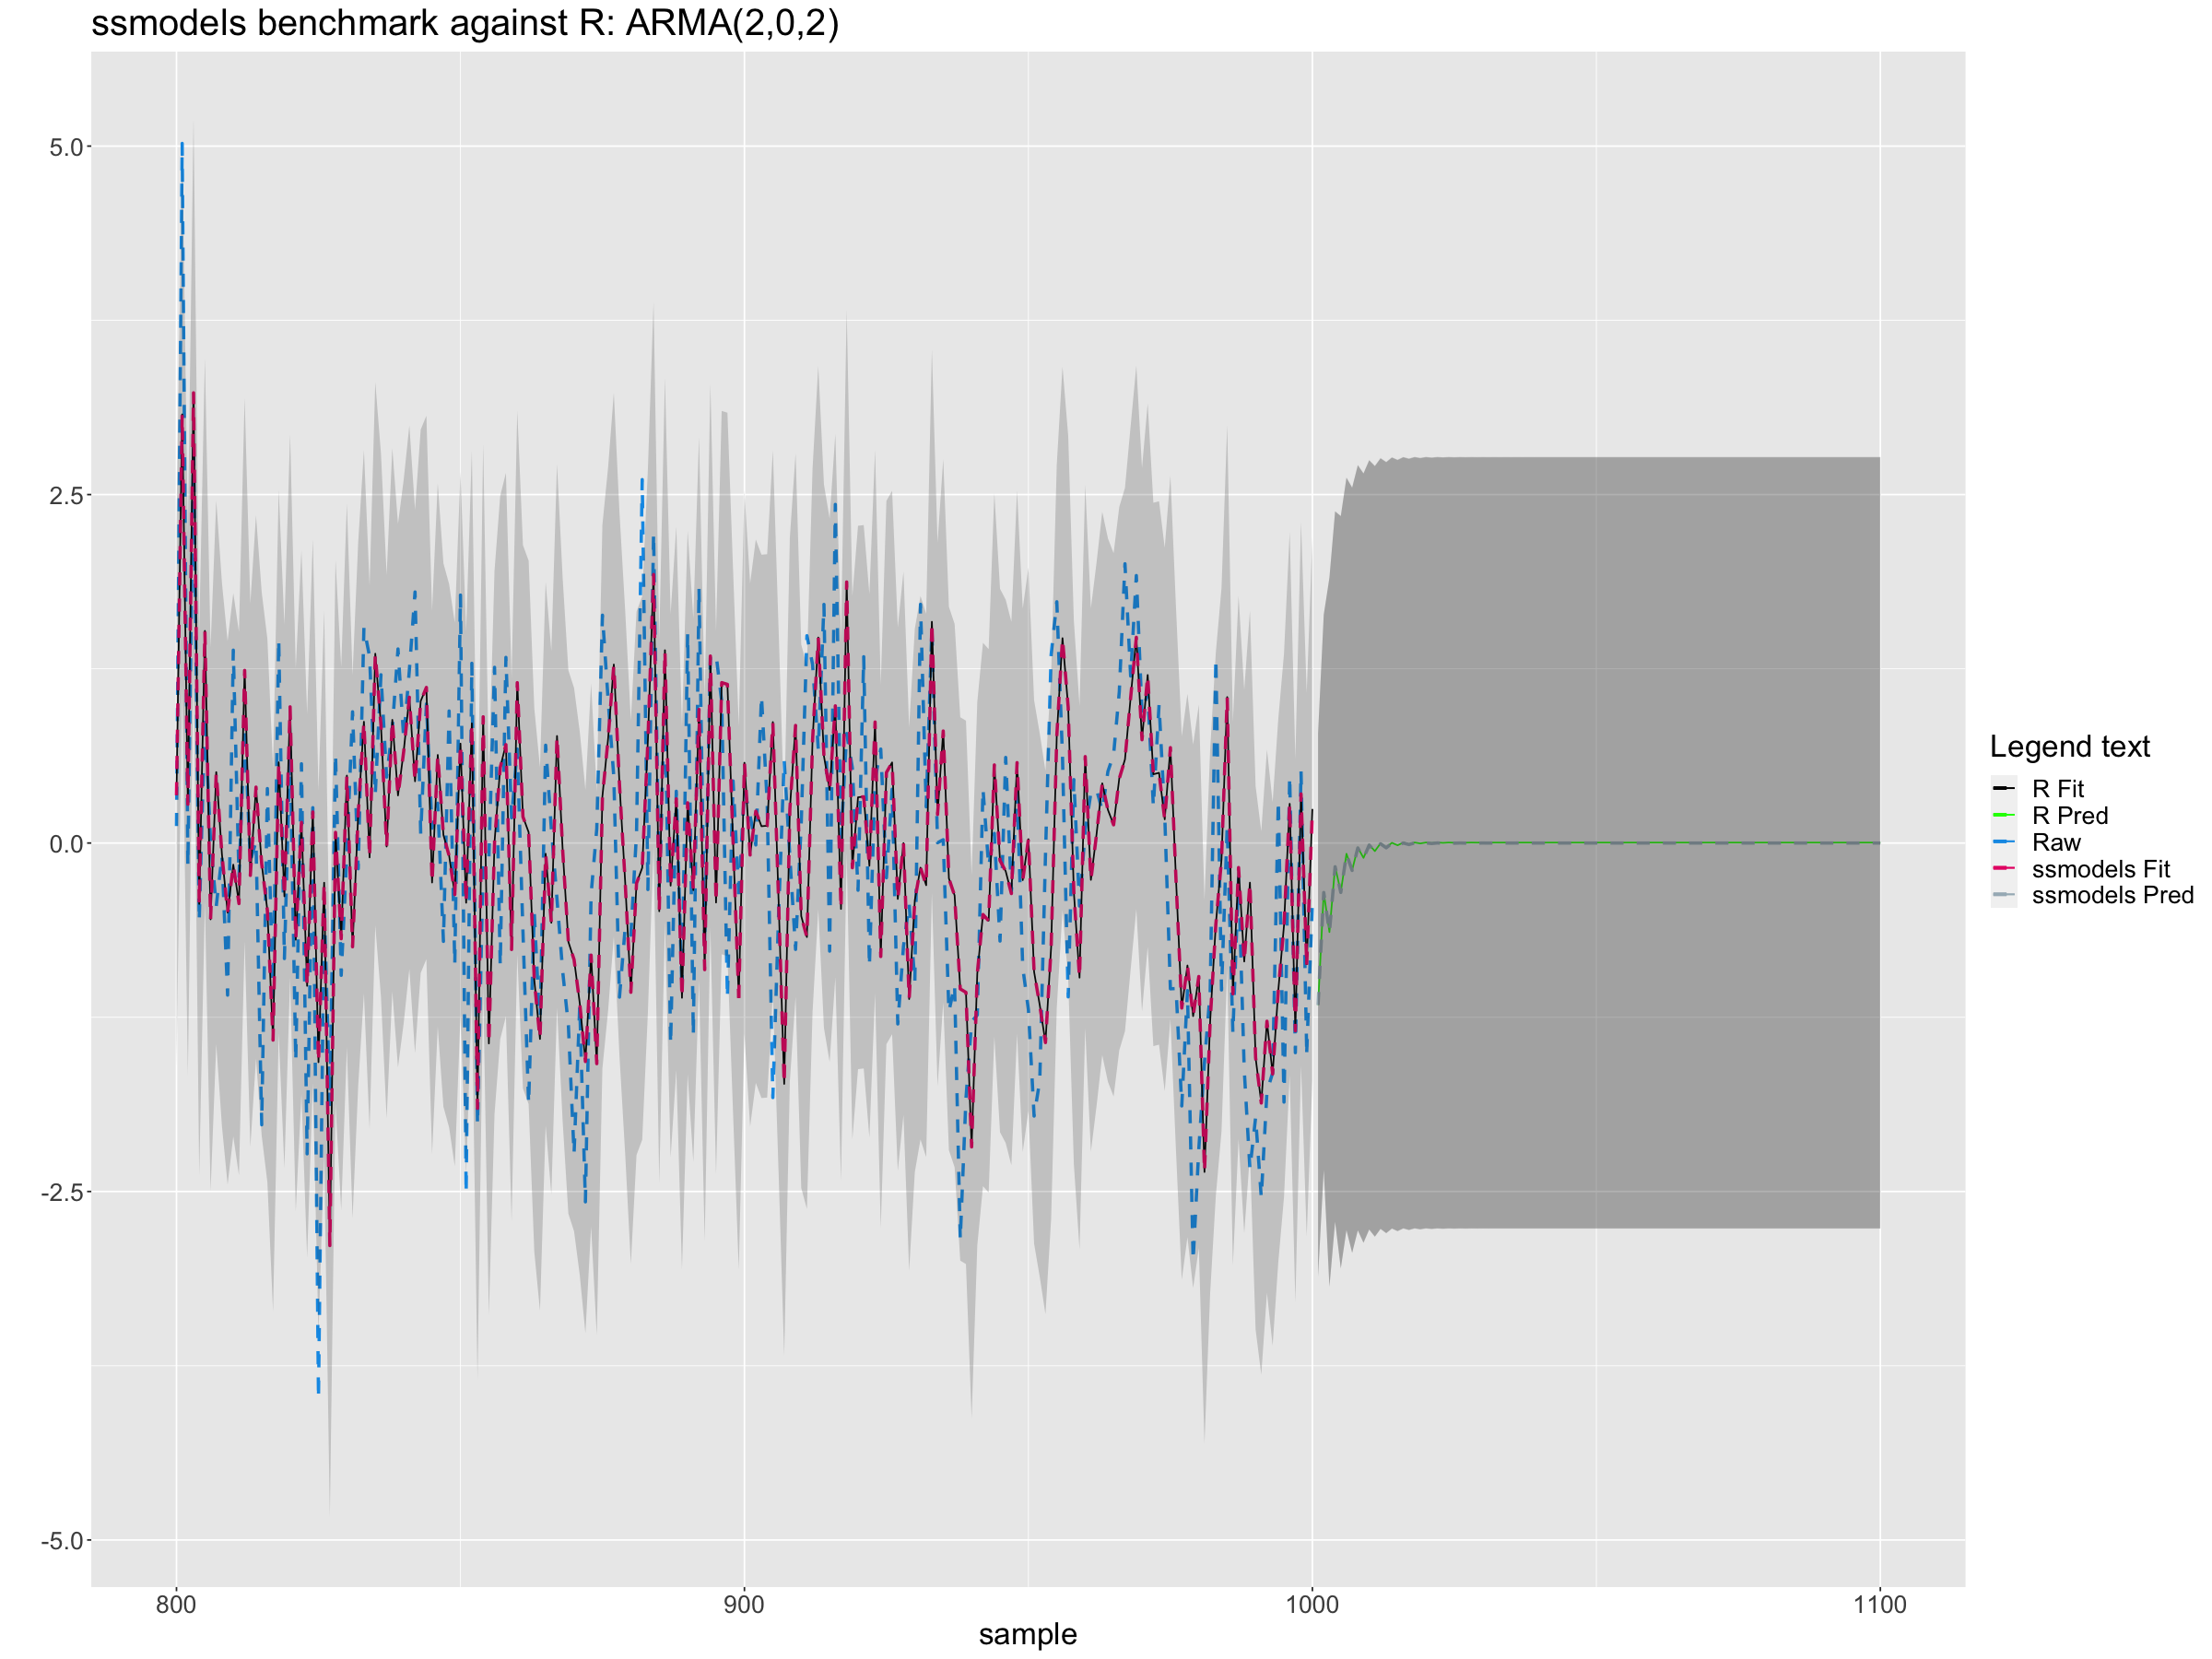

In [23]:
p0

### Numerical comparison between ssmodels and R

In [24]:
fit = data.frame(coef=y.est$coef[1:4], coef_ssmodel=coefsMLE, 
                 se = sqrt(diag(y.est$var.coef))[1:4], se_ssmodel = se_ssmodel) 
fit

,coef,coef_ssmodel,se,se_ssmodel
,<dbl>,<dbl>,<dbl>,<dbl>
ar1,-0.04764166,-0.04775893,0.03659862,0.03659773
ar2,0.56586728,0.56573294,0.03733193,0.03735608
ma1,0.25994007,0.25988920,0.04279244,0.04279802
ma2,0.25565927,0.25573292,0.04411713,0.04411008
